#### Summary:
We've settled on final methods for both RNA and ATAC trait associations and I'm making final versions of notebooks for these. In this notebook I'll implement the final ATAC trait associations! Unlike with RNA, where we find major differences between the gene expression counts data, the ATAC data looks much more comparable between the two datasets. Thus, here we'll run DESeq on both datasets combined, including covariates for dataset and sequencing depth. I'm still working on downstream analyses with peaks, but I'll try and add them here as we figure them out.

In [1]:
suppressMessages(library(dplyr)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressMessages(library(readr))
#suppressMessages(library(meta))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
#suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

#suppressMessages(library(DESeq2))
#suppressMessages(library(fgsea))
suppressMessages(library(parallel))
#suppressMessages(library(bettermc))
#suppressMessages(library(qvalue))

# Basic Inputs

In [2]:
alberta_samples <- c('R207','R217','R218','R221','R223',
                      'R226','R228','R234','R237','R238',
                      'R246', 'R247', 'R275', 'R284', 
                      'R290', 'R292', 'R316', 'R317', 'R319',
                      'R325','R326','R327','R332',
                      'R353','R354','R362','R363','R364')

hpap_samples_atac <- c('HPAP-035','HPAP-036','HPAP-039','HPAP-040','HPAP-044',
                       'HPAP-045','HPAP-047','HPAP-049','HPAP-050','HPAP-052',
                       'HPAP-053','HPAP-054','HPAP-056','HPAP-059','HPAP-063',
                       'HPAP-067','HPAP-069','HPAP-072','HPAP-075','HPAP-077',
                       'HPAP-080','HPAP-092','HPAP-099','HPAP-101','HPAP-103',
                       'HPAP-104','HPAP-105')
length(hpap_samples_atac)

[1] 27

In [3]:
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations'

In [4]:
#joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal', 'endothelial', 'immune','stellate')
#only run ATAC on larger cell types bc of data sparsity
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal')

# 1. Read in inputs previously generated (metadata df, cell type peaks lists)

## Donor metadata

In [5]:
meta_fp <- file.path(outdir, 'Alberta_HPAP_combined_metadata_all.tsv')
meta <- read.table(meta_fp, sep='\t')
dim(meta)
head(meta)
tail(meta)

[1] 62 56

,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,ductal_mean_genes,scaled_ductal_mean_genes,endothelial_mean_genes,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R207,50,0.4825992,Female,22.2,-0.93547849,NA,NA,Alberta,70,0.07402343,⋯,1842.333,-0.7227589,1304.000,-0.69291246,1118.606,-0.869054467,1314.583,-0.9386930,3.450389,-1.2548308
R217,71,1.5811029,Female,35.5,1.15230857,6.3,1.6527657,Alberta,15,-1.34420328,⋯,1868.313,-0.6980603,1578.500,-0.11854077,1458.000,0.009333767,1771.000,-0.3702339,3.530508,-1.1219687
R218,73,1.6857223,Female,28.4,0.03777563,5.9,0.8536262,Alberta,70,0.07402343,⋯,1384.827,-1.1577107,1503.500,-0.27547292,910.250,-1.408302494,1505.200,-0.7012832,3.641667,-0.9376335
R221,44,0.1687410,Male,30.5,0.36742622,5.3,-0.3450829,Alberta,136,1.77589549,⋯,1625.554,-0.9288509,1376.625,-0.54094982,1460.600,0.016062849,1243.706,-1.0269696,3.792649,-0.6872598
R223,54,0.6918380,Male,27.0,-0.18199143,5.8,0.6538414,Alberta,64,-0.08069221,⋯,1854.044,-0.7116253,1592.143,-0.08999406,1568.125,0.294349182,1826.053,-0.3016668,2.992320,-2.0144478
R226,30,-0.5635948,Female,32.3,0.64998386,4.9,-1.1442224,Alberta,16,-1.31841734,⋯,2238.235,-0.3463746,1328.000,-0.64269417,2198.750,1.926474909,1739.250,-0.4097780,3.864731,-0.5677271


,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,ductal_mean_genes,scaled_ductal_mean_genes,endothelial_mean_genes,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HPAP-092,21,-1.0343821,Male,25.59,-0.403328254,5.6,0.2542716,HPAP,48,-0.4932673,⋯,NA,NA,NA,NA,NA,NA,NA,NA,4.745936,0.8935767
HPAP-099,28,-0.6682142,Female,24.70,-0.543037312,5.0,-0.9444375,HPAP,NA,NA,⋯,3359.227,0.7193535,1974.645,0.7103648,1335.750,-0.3070625,3244.049,1.4644225,5.502476,2.1481485
HPAP-101,55,0.7441477,Female,38.01,1.546319508,5.0,-0.9444375,HPAP,96,0.7444579,⋯,2145.525,-0.4345142,1192.085,-0.9270865,1007.828,-1.1557611,1543.082,-0.6541014,5.359599,1.9112167
HPAP-103,48,0.3779798,Female,36.44,1.299866450,6.0,1.0534111,HPAP,144,1.9821830,⋯,2772.062,0.1611346,1754.500,0.2497267,1233.333,-0.5721279,1936.127,-0.1645711,5.255340,1.7383224
HPAP-104,4,-1.9236470,Male,20.63,-1.181931547,4.9,-1.1442224,HPAP,144,1.9821830,⋯,2889.504,0.2727869,1691.813,0.1185594,1325.455,-0.3337082,2231.083,0.2027913,4.768235,0.9305564
HPAP-105,51,0.5349089,Female,28.10,-0.009317313,5.2,-0.5448678,HPAP,48,-0.4932673,⋯,2729.804,0.1209606,1512.557,-0.2565211,1097.302,-0.9241927,1979.730,-0.1102645,4.832792,1.0376113


In [6]:
#subset down to samples in sample lists and remove any with NA culture time 
fin_samples <- c(alberta_samples,hpap_samples_atac)
meta_fin <- meta[fin_samples,] %>% subset(!is.na(culture_time))
dim(meta_fin)

[1] 52 56

## Read in cell type level called peaks (overlapping union peaks)

In [7]:
# Read in all celltype_peak files into a list
ct_peaks_list = list()
for (celltype in joint_celltypes){
    peak.fp <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/celltype_union_peaks/%s.union_peaks.bed',celltype)
    ct.peaks <- read.table(peak.fp,sep='\t')
    ct_peaks <- paste(ct.peaks$V1,ct.peaks$V2,ct.peaks$V3,sep="-")
    ct_peaks_list[[celltype]] = ct_peaks
}

In [8]:
#OPTION: cut down ct peaks lists to just autosomal peaks!
ct_auto_peaks_list <- list()
for (celltype in joint_celltypes){
    peaks <- ct_peaks_list[[celltype]]
    ct_auto_peaks_list[[celltype]] <- peaks[!grepl('chrX|chrY',ct_peaks_list[[celltype]])]
}

In [9]:
length(ct_peaks_list[['beta']])
length(ct_auto_peaks_list[['beta']])

[1] 128874

[1] 125823

In [10]:
head(ct_peaks_list[['beta']])

[1] "chr1-9956-10256"    "chr1-180714-181014" "chr1-181329-181629"
[4] "chr1-191340-191640" "chr1-267860-268160" "chr1-586035-586331"

# 2. Calculate Trait Associations with Peaks

## Run DESeq for all variables (age, BMI, HbA1c, sex)
Function design: `~main variable + other metadata + dataset + scaled_culture_time + scaled_beta_prop_atac + scaled_tsse`

In [11]:
mat_dir <- file.path(outdir, 'ATAC','merged_sample_matrices')
files <- list.files(mat_dir)
files

#exclude cell types that we don't have many donors with lots of cells in (endothelial)
#already did this by deleting softlinks for 3 small cell types
fin_files <- files

[1] "acinar_sample_ATAC_total_counts.txt" "alpha_sample_ATAC_total_counts.txt" 
[3] "beta_sample_ATAC_total_counts.txt"   "delta_sample_ATAC_total_counts.txt" 
[5] "ductal_sample_ATAC_total_counts.txt" "gamma_sample_ATAC_total_counts.txt"

In [13]:
### Function which runs the default DESeq analysis on each cell type total counts sample matrix
### focusing on one input variable (var), and including other_vars as covariates
### then sorts results by pvalue and writes to a file.
### Samples with NA values for the variable of interest (var) are removed, as well as samples with 
### no gex (eg some samples don't have schwann cells).

### New features: filter out genes with pseudobulk TPM < set cutoff, option to include scaled_mean_genes covar,
### writes outputs to a log file!
### 3/15/24: option to only use samples with a certain number of cells in the cell type

run_deseq_one_main_variable_ATAC <- function(files, var, other_vars, meta, out_prefix, log_fp, only_auto_peaks=TRUE, min_cells_per_sample=20){
    write(sprintf('Starting DESeq run for %s: %s', var, Sys.time()), file=log_fp, append=TRUE)
    
    for (FILE in files) {
        # Read in cell type counts file (sample pseudobulk)
        cell <- gsub('_sample_ATAC_total_counts.txt', '', FILE)
        print(FILE)
        raw_counts <- read.table(file.path(mat_dir, FILE), row.names=1)
        raw_counts <- raw_counts[,(colSums(raw_counts != 0) > 0)]
        colnames(raw_counts) <- gsub('\\.','-',colnames(raw_counts))
        meta_cell <- meta
        
        # Identify which samples we have peak counts and enough cells from and cut down matrices accordingly
        samples <- row.names(meta_cell)
        samples_meta <- row.names(meta_cell[!is.na(meta_cell[,var]),])
        cell_col <- paste0(cell,'_cells_atac')
        samples_w_cells <- row.names(meta %>% subset(meta[[cell_col]] >= min_cells_per_sample & num_cells_atac > 1000))
        samples_fin <- samples[samples %in% samples_meta & samples %in% samples_w_cells]
        meta_fin <- meta_cell[samples_fin,]
        raw_counts_fin <- raw_counts[,samples_fin]
        write(paste(cell, Sys.time(), length(samples_fin), 'samples to use'), file=log_fp, append=TRUE)
        write(paste(cell, Sys.time(), paste(samples_fin, collapse=',')), file=log_fp, append=TRUE)
        
        # If there are at least 10 samples with metadata, proceed with DESeq
        if (length(meta_fin[,var]) > 10){            
            # Light pre-filtering
            counts <- raw_counts_fin[rowSums(raw_counts_fin) >= 10,]
            write(paste(dim(counts)[1], 'peaks pass light pre-filtering (>= 10 counts across samples)'), file=log_fp, append=TRUE)
            
            # Filter peaks (raw_counts_fin) for those called in the cell type
            if(only_auto_peaks==TRUE) ct_peaks <- ct_auto_peaks_list[[cell]]
            if(only_auto_peaks==FALSE) ct_peaks <- ct_peaks_list[[cell]]
            counts_fin <- counts[row.names(counts) %in% ct_peaks,]
            write(paste(dim(counts_fin)[1], 'peaks called in cell type'), file=log_fp, append=TRUE)

            # Make function for DESeq using in the format: ~var + other_vars
            my_design <- as.formula(paste0(sprintf('~ %s',var),paste0(rep(' + ',length(other_vars)), other_vars,collapse='')))  
            write(as.character(my_design), file=log_fp, append=TRUE)
            print(my_design)
            
            # Run DESeq            
            dds  <- DESeqDataSetFromMatrix(round(counts_fin), colData = meta_fin, design = my_design) #colData is where design columns are found
            rld <- vst(dds)
            print(plotPCA(rld, intgroup = var)+ ggtitle(paste(cell,var)))
            dds <- DESeq(dds)
            
            # Extract results for variable of interest
            if (var == 'sex'){
                fin_var <- 'sex_Male_vs_Female'
            } else{
                fin_var <- var
            }
            res <- results(dds, name=fin_var)
            df <- as.data.frame(res)
            df <- df[order(df$pvalue),]
            fp <- paste0(out_prefix, cell, '.tsv')
            write.table(df, fp, sep="\t", quote=FALSE)
            write('\n', file=log_fp, append=TRUE)
        } else {
            write(paste(cell, Sys.time(), 'not enough samples to proceed!'), file=log_fp, append=TRUE)
        }
        write('', file=log_fp, append=TRUE)
    }
    write(paste('Done', Sys.time()), file=log_fp, append=TRUE)
}

[1] "scaled_age 2024-04-02 16:48:44"
[1] "scaled_BMI"            "sex"                   "dataset"              
[4] "scaled_culture_time"   "scaled_beta_prop_atac" "scaled_tsse"          
[1] "acinar_sample_ATAC_total_counts.txt"
~scaled_age + scaled_BMI + sex + dataset + scaled_culture_time + 
    scaled_beta_prop_atac + scaled_tsse
<environment: 0x557dcfd46850>


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "alpha_sample_ATAC_total_counts.txt"
~scaled_age + scaled_BMI + sex + dataset + scaled_culture_time + 
    scaled_beta_prop_atac + scaled_tsse
<environment: 0x557dcfd46850>


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "beta_sample_ATAC_total_counts.txt"
~scaled_age + scaled_BMI + sex + dataset + scaled_culture_time + 
    scaled_beta_prop_atac + scaled_tsse
<environment: 0x557dcfd46850>


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


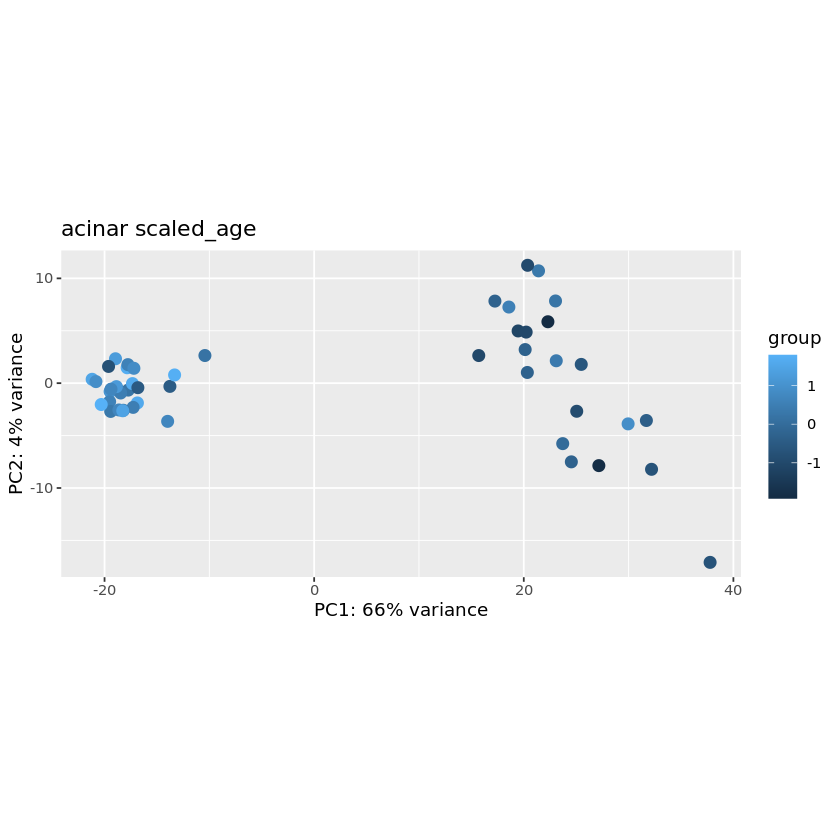

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [ ]:
# Use function to run deseq on all cell types for each variable of interest
variables <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
add_variables <- c('dataset', 'scaled_culture_time', 'scaled_beta_prop_atac', 'scaled_tsse')

deseq_outdir <- file.path(outdir,'ATAC','DESeq')
dir.create(deseq_outdir, showWarnings=FALSE)

for (var in variables){
    print(paste(var, Sys.time()))
    
    # Make subdir in the outdir for the specific variable
    outdir_var <- file.path(deseq_outdir, var)
    dir.create(outdir_var, showWarnings = F)
    out_prefix <- file.path(outdir_var, sprintf('ATAC_deseq_v4.%s.',var))
    log_fp <- file.path(deseq_outdir, sprintf('log_%s.txt', var))
    
    # Set other metadata variables to include in functions
    # removing HbA1c from other analyses for now since has NA values
    other_vars <- c(variables[variables != var & variables != 'scaled_HbA1c'] ,add_variables)
    print(other_vars)

    # Run DESeq
    run_deseq_one_main_variable_ATAC(fin_files, var, other_vars, meta_fin, out_prefix, log_fp, only_auto_peaks=TRUE, min_cells_per_sample=20)
    print('')
}

# 3. Visualize summaries of DESeq results

In [39]:
joint_celltypes
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#752BBA', '#F598C9','#FDBB84')
names(colors) <- joint_celltypes
colors

[1] "beta"   "alpha"  "delta"  "gamma"  "acinar" "ductal"

beta     alpha     delta     gamma    acinar    ductal      <NA>      <NA> 
"#3F98E0" "#F51646" "#E39E14" "#A1D99B" "#09850B" "#F5DE6C" "#752BBA" "#F598C9" 
     <NA> 
"#FDBB84"

In [30]:
#super brief summary of sig results from each association (in df form)
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')

summary_df <- data.frame()
for(celltype in joint_celltypes){
    num_sig <- c()
    for(trait in traits){
        fp <- file.path(deseq_outdir,trait,sprintf('ATAC_deseq_v4.%s.%s.tsv',trait, celltype))
        df <- read.table(fp, sep='\t', header=1)
        sig_peaks <- row.names(subset(df, padj<0.1))
        num_sig <- c(num_sig,length(sig_peaks))
    }
    summary_df <- rbind(summary_df, num_sig)
}
row.names(summary_df) <- joint_celltypes
colnames(summary_df) <- traits
summary_df

,scaled_age,scaled_BMI,scaled_HbA1c,sex
,<int>,<int>,<int>,<int>
beta,548,57,9,45
alpha,15,5,24,249
delta,5,1,1,24
gamma,0,2,0,17
acinar,12,36,84,24
ductal,0,0,1,1


## Basic summary plots

In [ ]:
### Function to make a barplot comparing the # of significant DEGs for a list of cell types and variables
summarize_DEGs <- function(deseq_outdir, variables, celltypes, plot_col, colors){
    # Organize list of all outputs (celltype and variable)
    prefixes <- paste(rep(variables, each = length(celltypes)), celltypes, sep='-')
    
    # Read in all deseq_output files, save summary info to a list
    data <- data.frame()
    for (prefix in prefixes){
        var <- str_split(prefix, '-')[[1]][1]
        cell <- str_split(prefix, '-')[[1]][2]
        fp <- file.path(deseq_outdir, var, sprintf('ATAC_deseq_v4.%s.%s.tsv',var, cell))
        df <- read.table(fp, sep='\t', header=TRUE)
        
        # Collect summary information into a vector
        num_tested <- dim(df)[1]
        num_sig <- dim(df[df$padj <= 0.1 & !is.na(df$padj),])[1]
        num_sig_pos <- dim(df[df$padj <= 0.1 & !is.na(df$padj) & df$log2FoldChange > 0,])[1]
        num_sig_neg <- dim(df[df$padj <= 0.1 & !is.na(df$padj) & df$log2FoldChange < 0,])[1]
        data <- rbind(data, c(num_tested, num_sig, num_sig_pos, num_sig_neg))
    }
    
    # Clean up dataframe
    row.names(data) <- prefixes
    colnames(data) <- c('genes_tested', 'sig_genes', 'pos_sig_genes', 'neg_sig_genes')
    data$variable <- str_split_fixed(prefixes, '-', 2)[,1]
    data$celltype <- str_split_fixed(prefixes, '-', 2)[,2]
    #print(data)
    
    # replace column name of plot_col with literally "plot_col" and make colors vector
    data$plot_col <- data[,plot_col]
    
    # Make grouped barplot of desired metadata
    options(repr.plot.width=30, repr.plot.height=8)
    theme_set(
        theme_classic())
    
    p1 <- ggplot(data, aes(fill=celltype, y=plot_col, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            labs(x = "Cell type", y = plot_col, color="Cell Type") + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
    
}

In [ ]:
### Function to make a barplot comparing the chromosomes which DEGs come from (specifically for sex results)
### designed for one variable only
summarize_DEGs_chroms_ATAC <- function(deseq_outdir, var, celltypes, ref_df, colors){
    # Read in DESeq outputs and record chromosome distribution of genes    
    test_list <- list()

    for (cell in celltypes){
        fp <- file.path(deseq_outdir, var, sprintf('ATAC_deseq_v4.%s.%s.tsv',var, cell))
        df <- read.table(fp, sep='\t', header=TRUE)
        df_cut <- df[df$padj <= 0.1 & !is.na(df$padj),]
        #get chroms for each peak
        peaks <- as.data.frame(str_split_fixed(row.names(df_cut),'-',3))
        test_list[[cell]] <- table(peaks$V1)
    }
    
    # Reformat into dataframe
    data <- plyr::ldply(test_list, rbind)
    chromosomes <- paste0('chr',c(as.character(seq(1,22)),'X','Y'))
    prev_chroms <- colnames(data)
    missing_chroms <- chromosomes[!chromosomes %in% colnames(data)]
    for (chrom in missing_chroms){
        new_col <- rep(NA, dim(data)[1])
        data <- cbind(data, new_col)
    }
    colnames(data) <- c(prev_chroms, missing_chroms)
    data2 <- t(data[,-1])
    colnames(data2) <- celltypes
    data2[is.na(data2)] <- 0
    data_fin <- data2[chromosomes,]

    # final df reformatting for ggplot
    df <- reshape2::melt(data_fin)
    colnames(df) <- c('chrom', 'celltype', 'num_genes')
    
    # Make grouped barplot of #genes in each celltype by chromosome
    options(repr.plot.width=24, repr.plot.height=8)
    theme_set(
        theme_classic())
    
    p1 <- ggplot(df, aes(fill=celltype, y=num_genes, x=chrom)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            labs(x = "Celltype", y = 'Number of peaks', color="Cell Type", title=var) + 
           scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

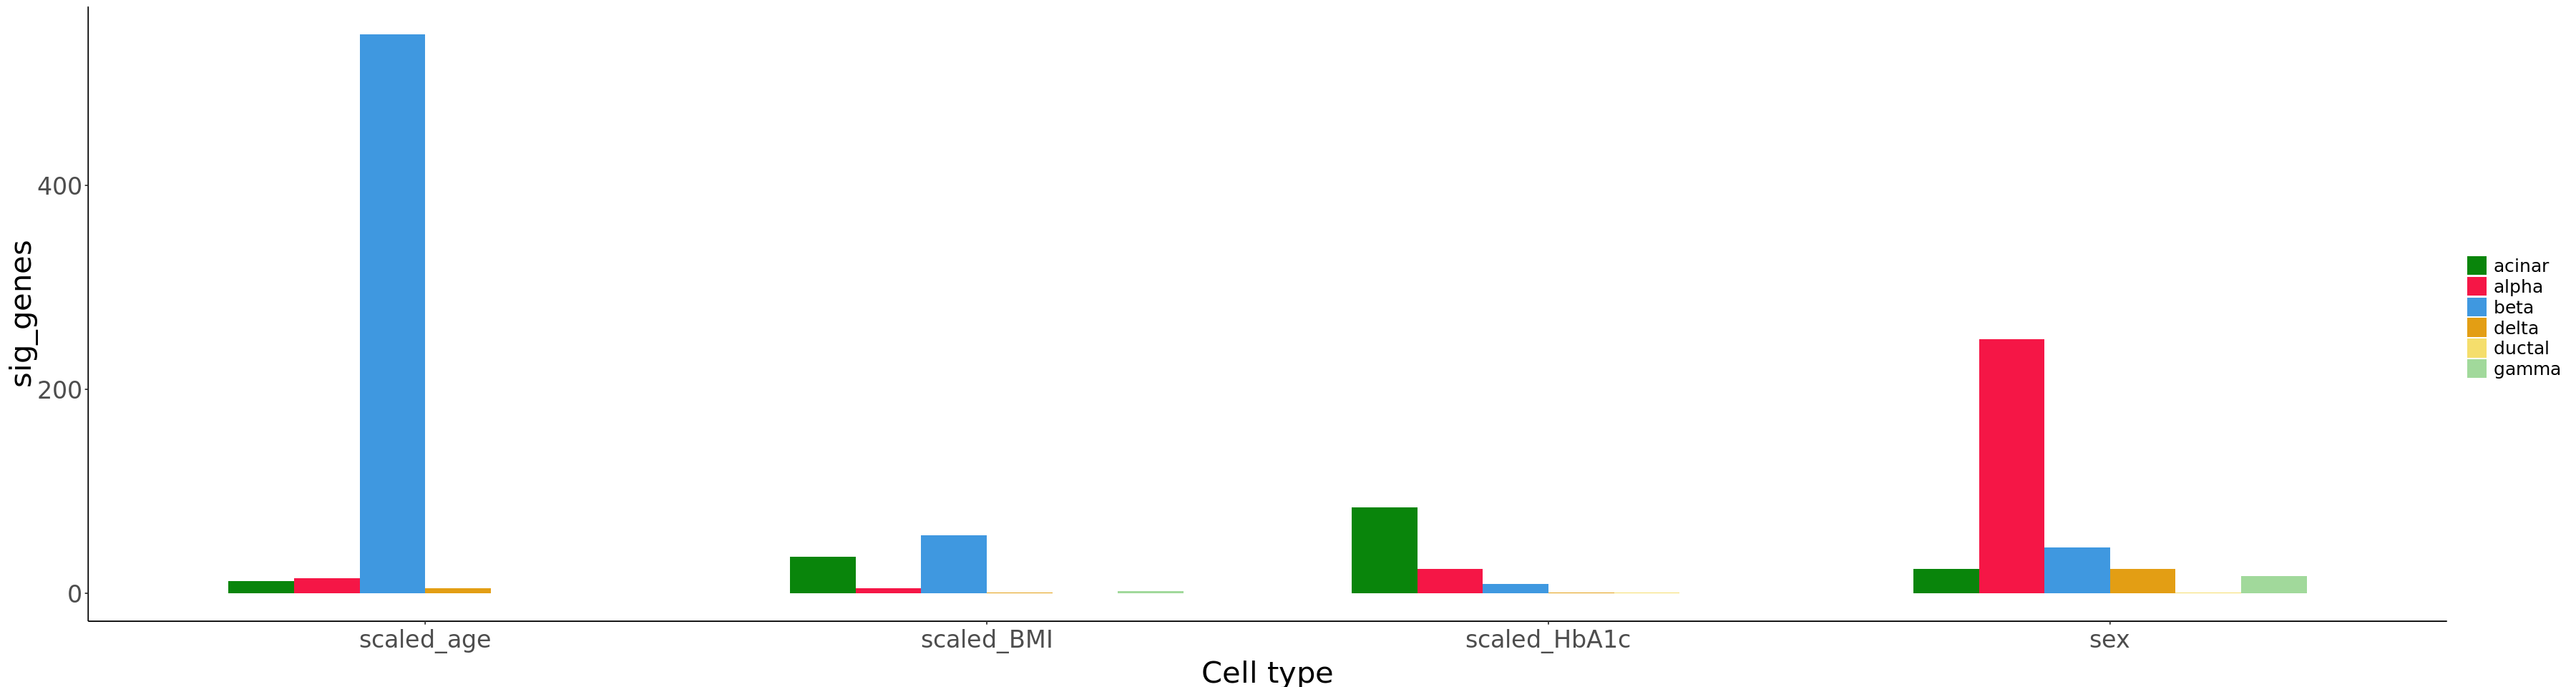

In [27]:
variables <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
summarize_DEGs(deseq_outdir, variables, joint_celltypes,'sig_genes', colors)

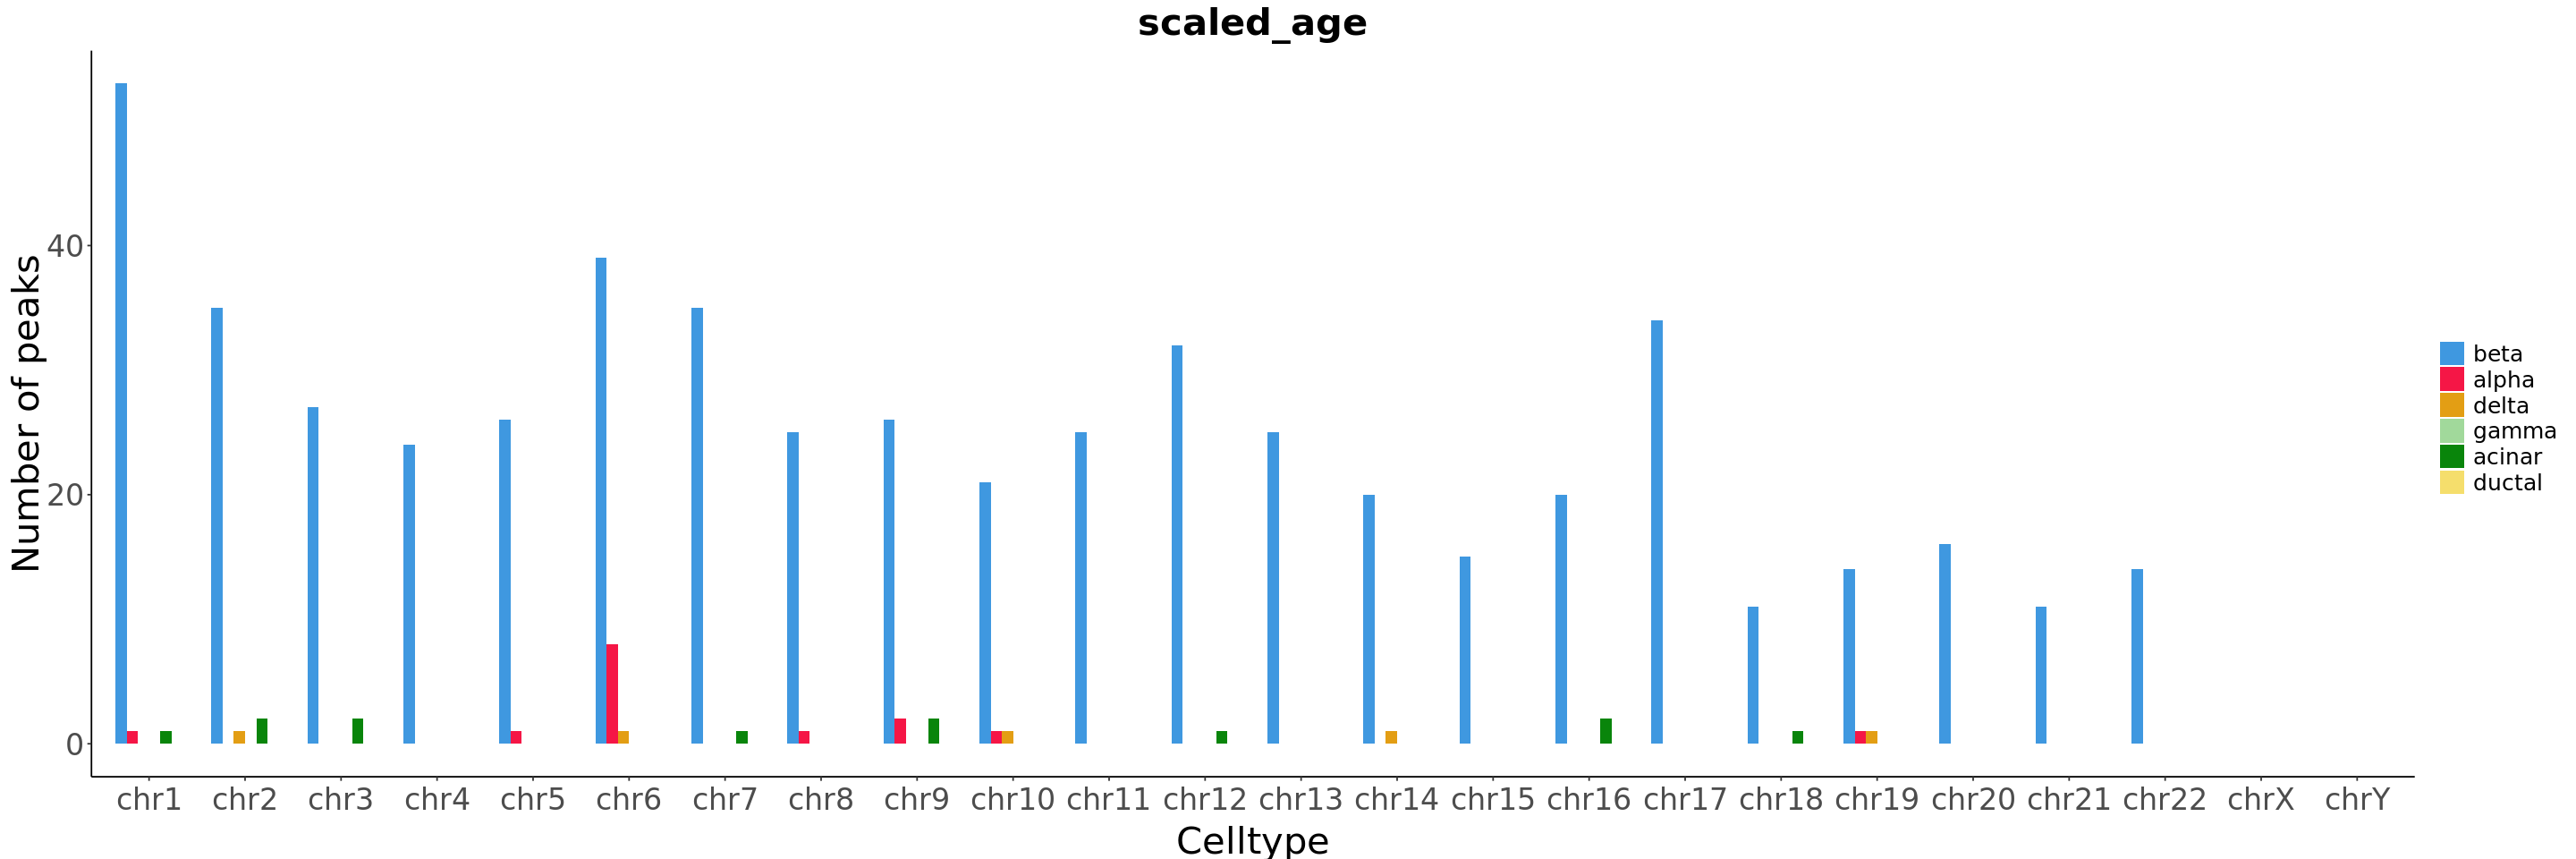

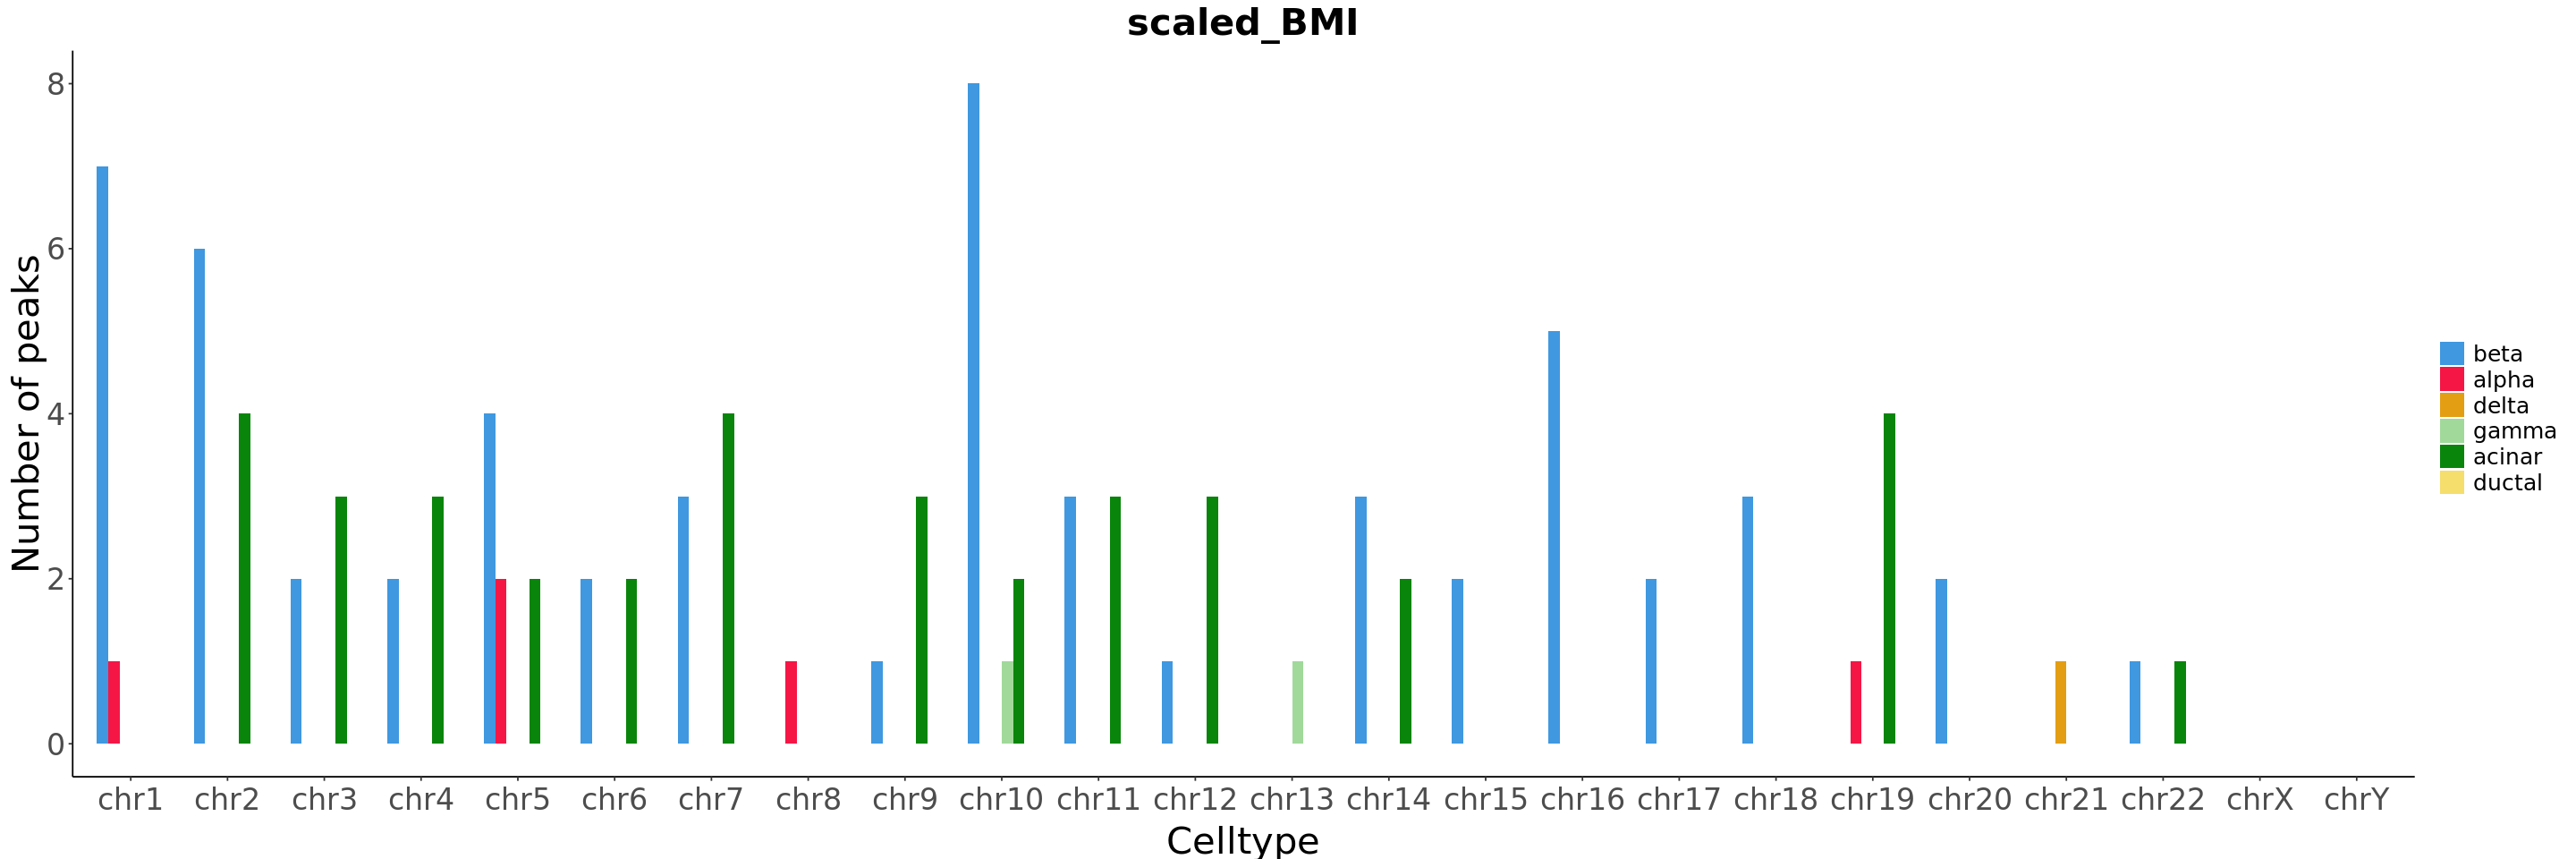

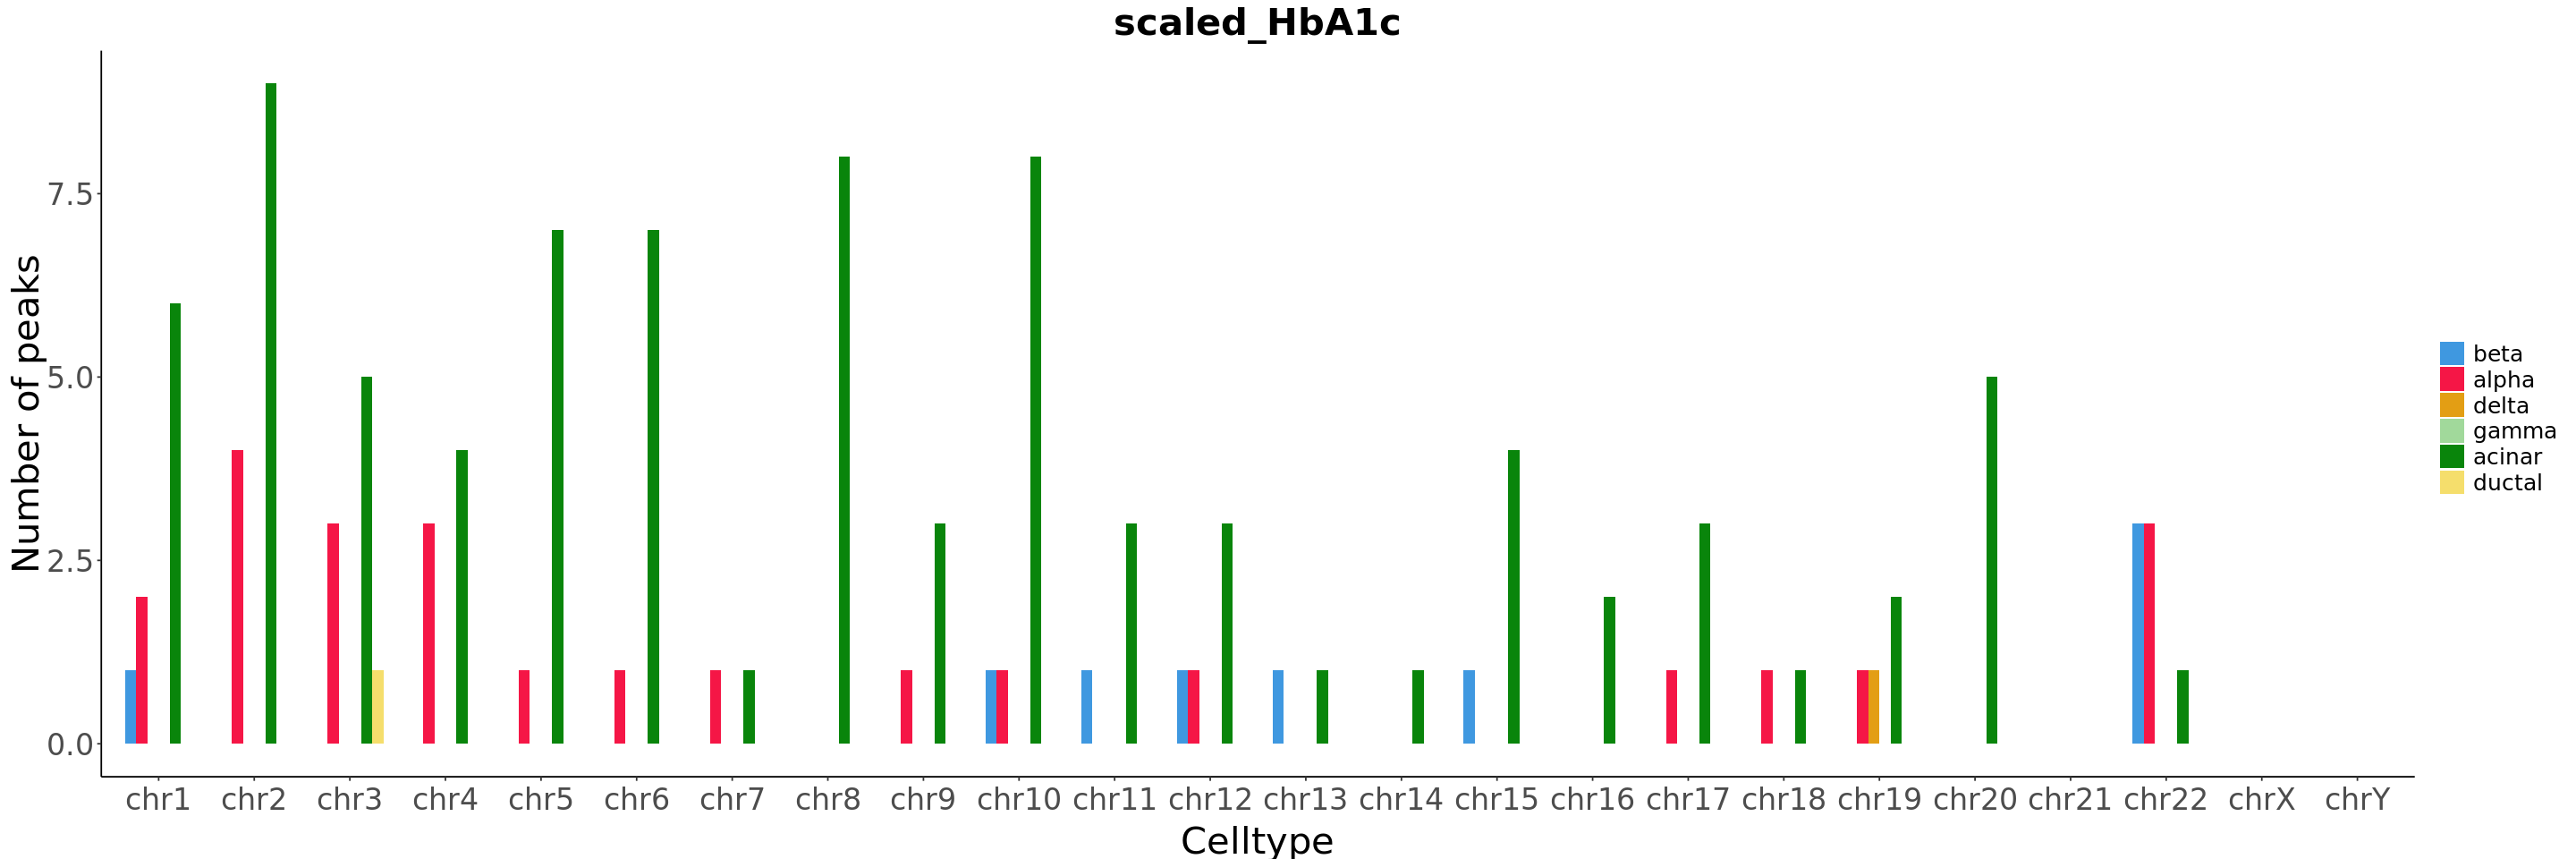

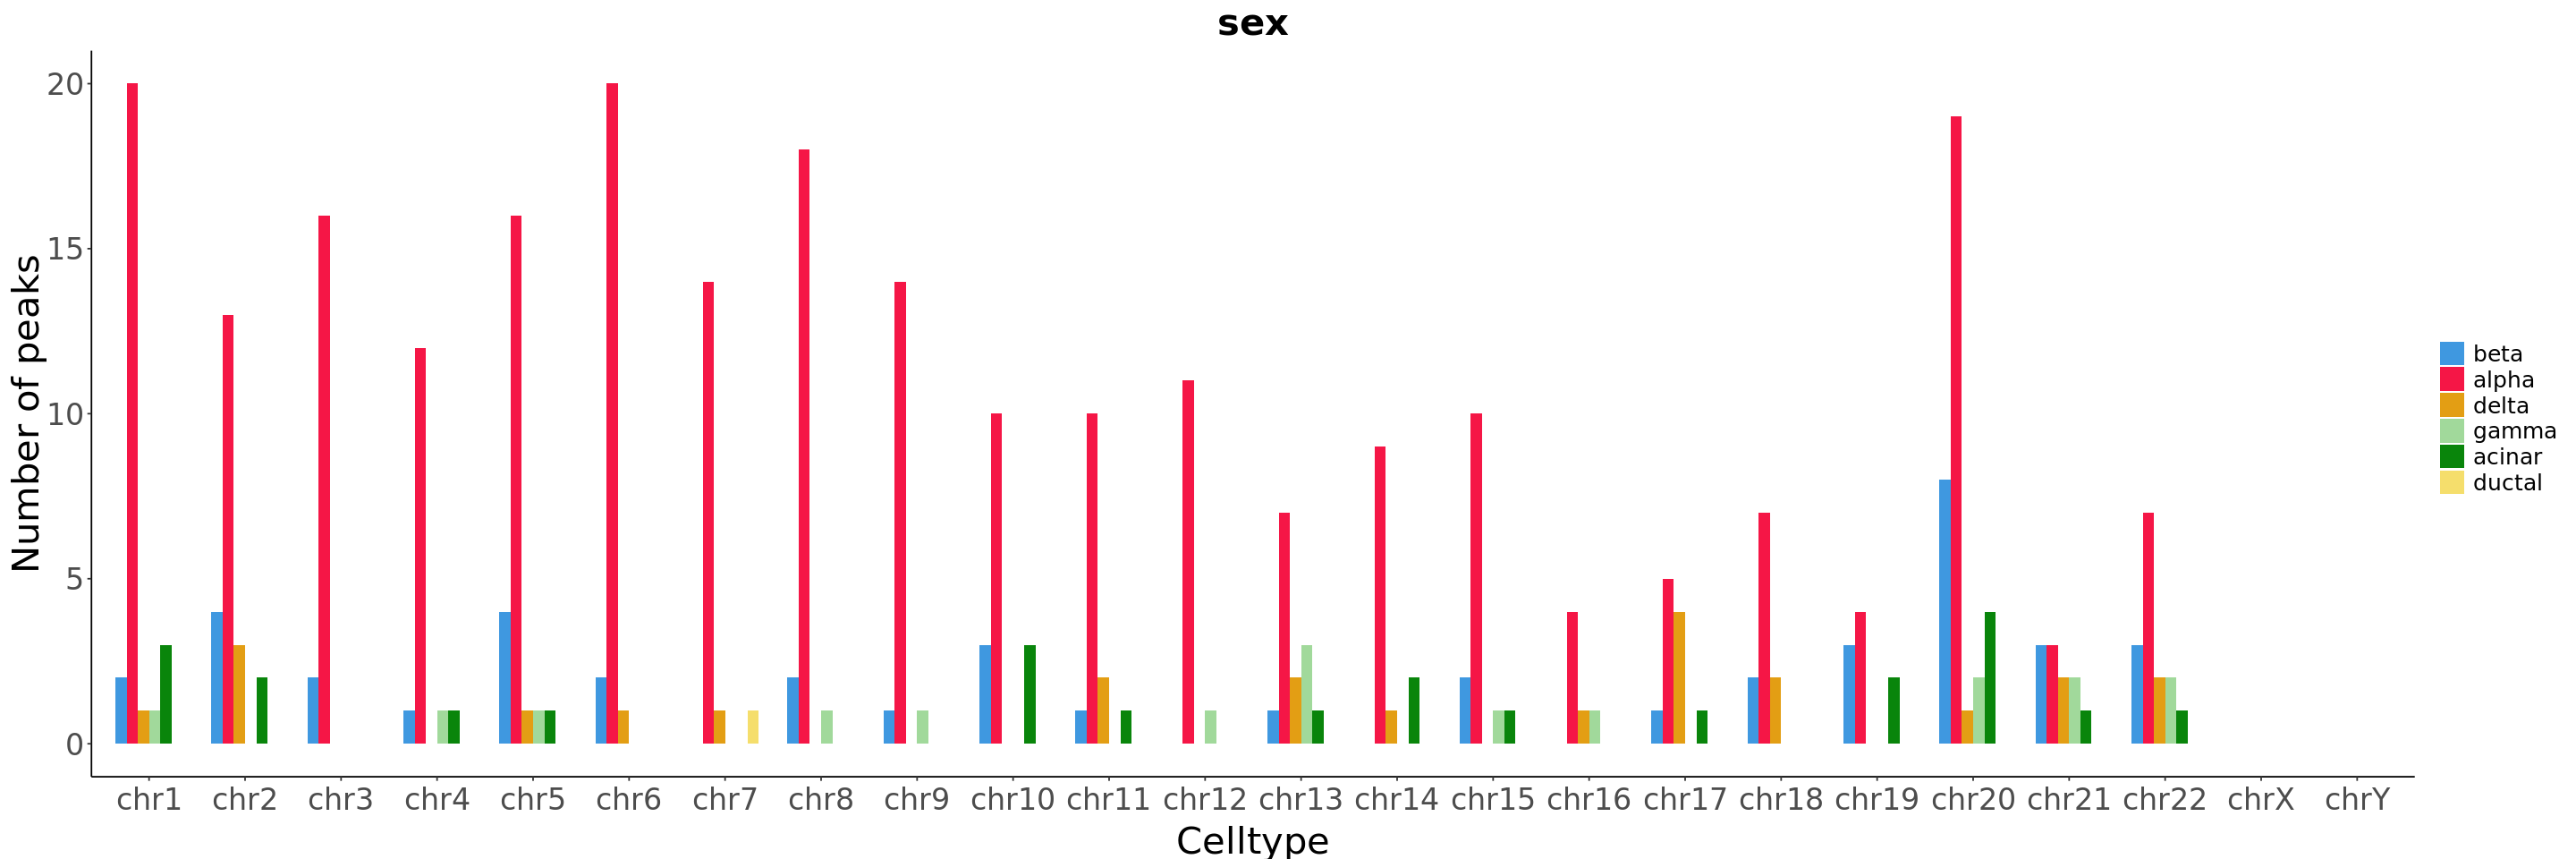

In [28]:
ref_df <- read.table('/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE)
variables <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
for (var in variables){
    summarize_DEGs_chroms_ATAC(deseq_outdir, var, joint_celltypes, ref_df, colors)    
}

## Volcano plots -- based on code from Ruth

In [ ]:
### Function which reads in a DESeq output file and makes a Volcano plot using Ruth's function EnhancedVolcano()
make_volcano_plot <- function(fp, plot_title, cell, pos_color, neg_color){
    # Read in DESeq results dataframe
    df <- read.table(fp, sep='\t', header=TRUE)
    sig <- df[which(df$padj <= 0.1),]

    # Select for significant genes
    sig_genes <- row.names(sig)
    down <- sig[which(sig$log2FoldChange < 0),]
    up <- sig[which(sig$log2FoldChange > 0),]
    
    # Add information about down and up regulated genes to initial df (keyvals and color)
    # Defaults: 
    df$keyvals <- "mid"
    df$color <- "black"
    
    # Check if there are any significant genes before adding their info
    if (dim(down)[1] == 0 && dim(up)[1] == 0){
        print(sprintf('No genes in %s cells pass the padj cutoff!', cell))
    }
    if (dim(down)[1] > 0) {
        df[row.names(df) %in% row.names(down),"keyvals"] <- "low"
        df[row.names(df) %in% row.names(down),]$color <- neg_color
    } 
    if(dim(up)[1] > 0){
        df[row.names(df) %in% row.names(up),"keyvals"] <- "high"
        df[row.names(df) %in% row.names(up),]$color <- pos_color
    }
    
    # Final sorting
    keyvals.color <- df$color
    names(keyvals.color) <- df$keyvals

    ### Optional, set things with extreme effect sizes to a max value
    # max_l2fc <- 2.5
    # df[which(df$log2FoldChange > max_l2fc),]$log2FoldChange <- max_l2fc
    # df[which(df$log2FoldChange < -max_l2fc),]$log2FoldChange <- -max_l2fc

    #Make the volcano plot with Ruth's crazy function
    #Will likely have to change the axis labels in the source code --> do this later ### TO DO ###############
    source("/nfs/lab/relgamal/Scripts/enhanced_volcano.r")
    options(repr.plot.width=10, repr.plot.height=10)  
    p1 <- EnhancedVolcano(df, #dataframe with results
        lab = rownames(df), #where labels for each row in results are held
        selectLab = sig_genes, #use if you only want specific genes/proteins labeled on plot
        x = 'log2FoldChange', #column in results dataframe that you want on x axis
        y = 'pvalue', #column in results dataframe that you want on y axis
        pCutoff = 0.001, #sets horizontal dashed line
        FCcutoff = 0, #sets vertical dashed line
        title = plot_title,
        xlab = 'Log2(Fold Change)',
        ylab = '-Log10(p-value)',
        legendPosition = 'none',
        drawConnectors = FALSE, #can change this to TRUE if you want arrows connecting labels to dots. I manually move in illustrator
        widthConnectors = 0,
        typeConnectors = 'open',
        colCustom = keyvals.color) + ggplot2::coord_cartesian(ylim=c(0, 11),xlim=c(-2.5, 2.5))   
    return(p1)
}

Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No genes in gamma cells pass the padj cutoff!"


Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No genes in ductal cells pass the padj cutoff!"


Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No genes in ductal cells pass the padj cutoff!"


Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No genes in gamma cells pass the padj cutoff!"


Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


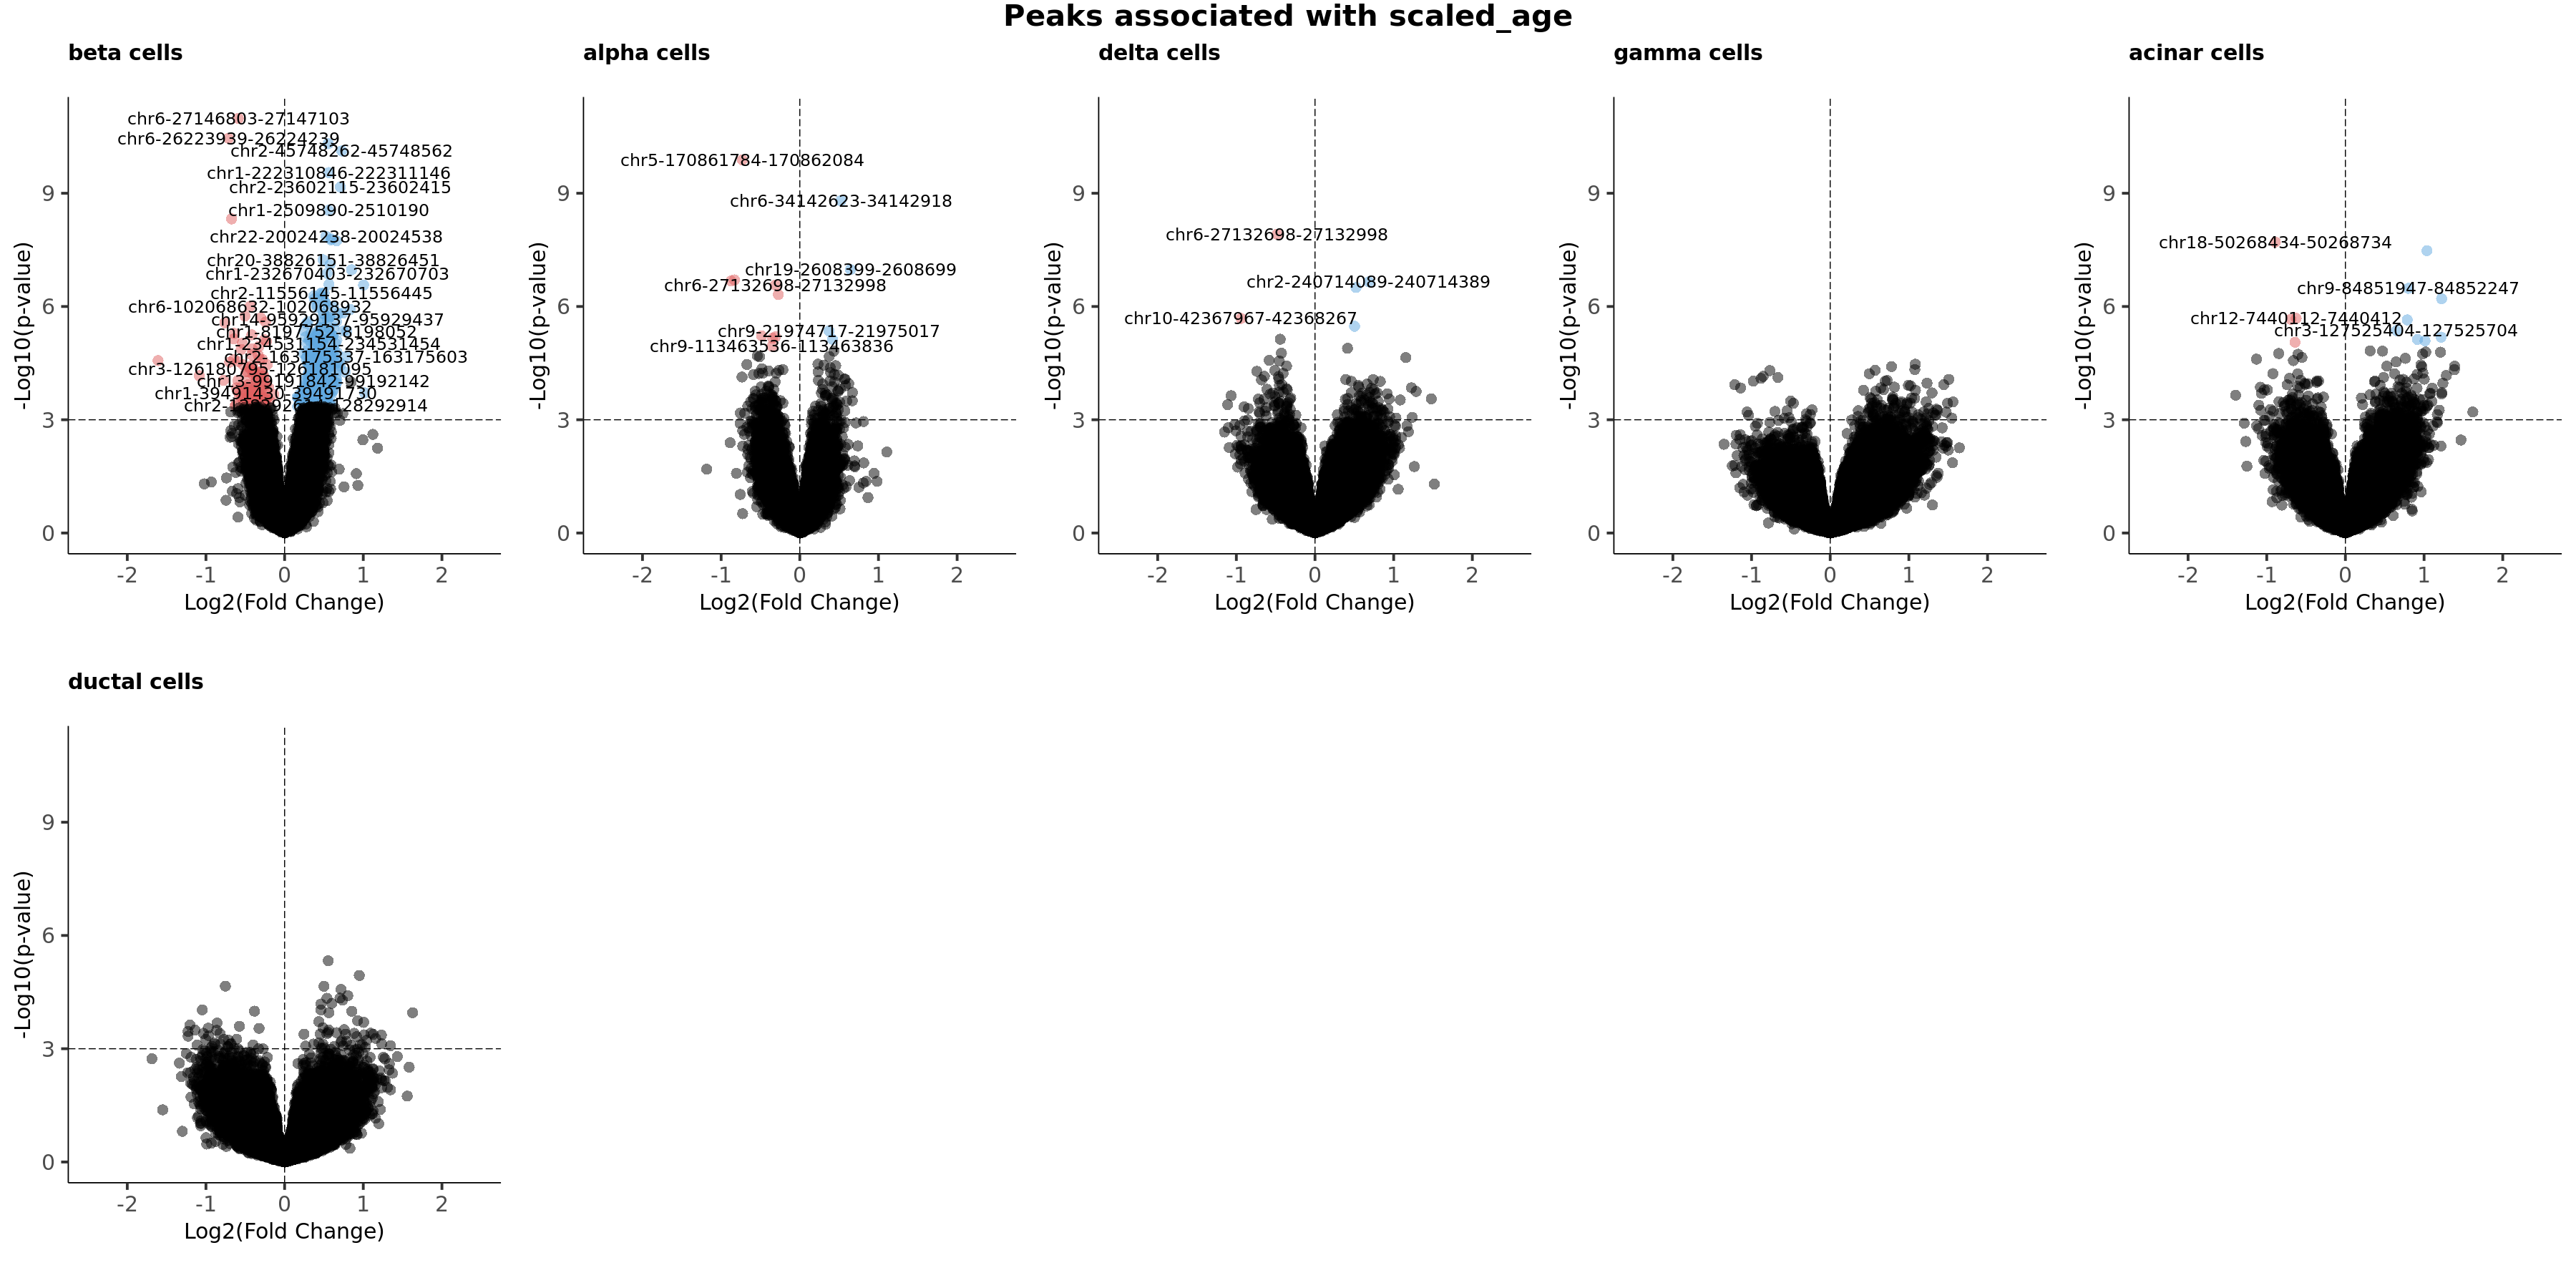

Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


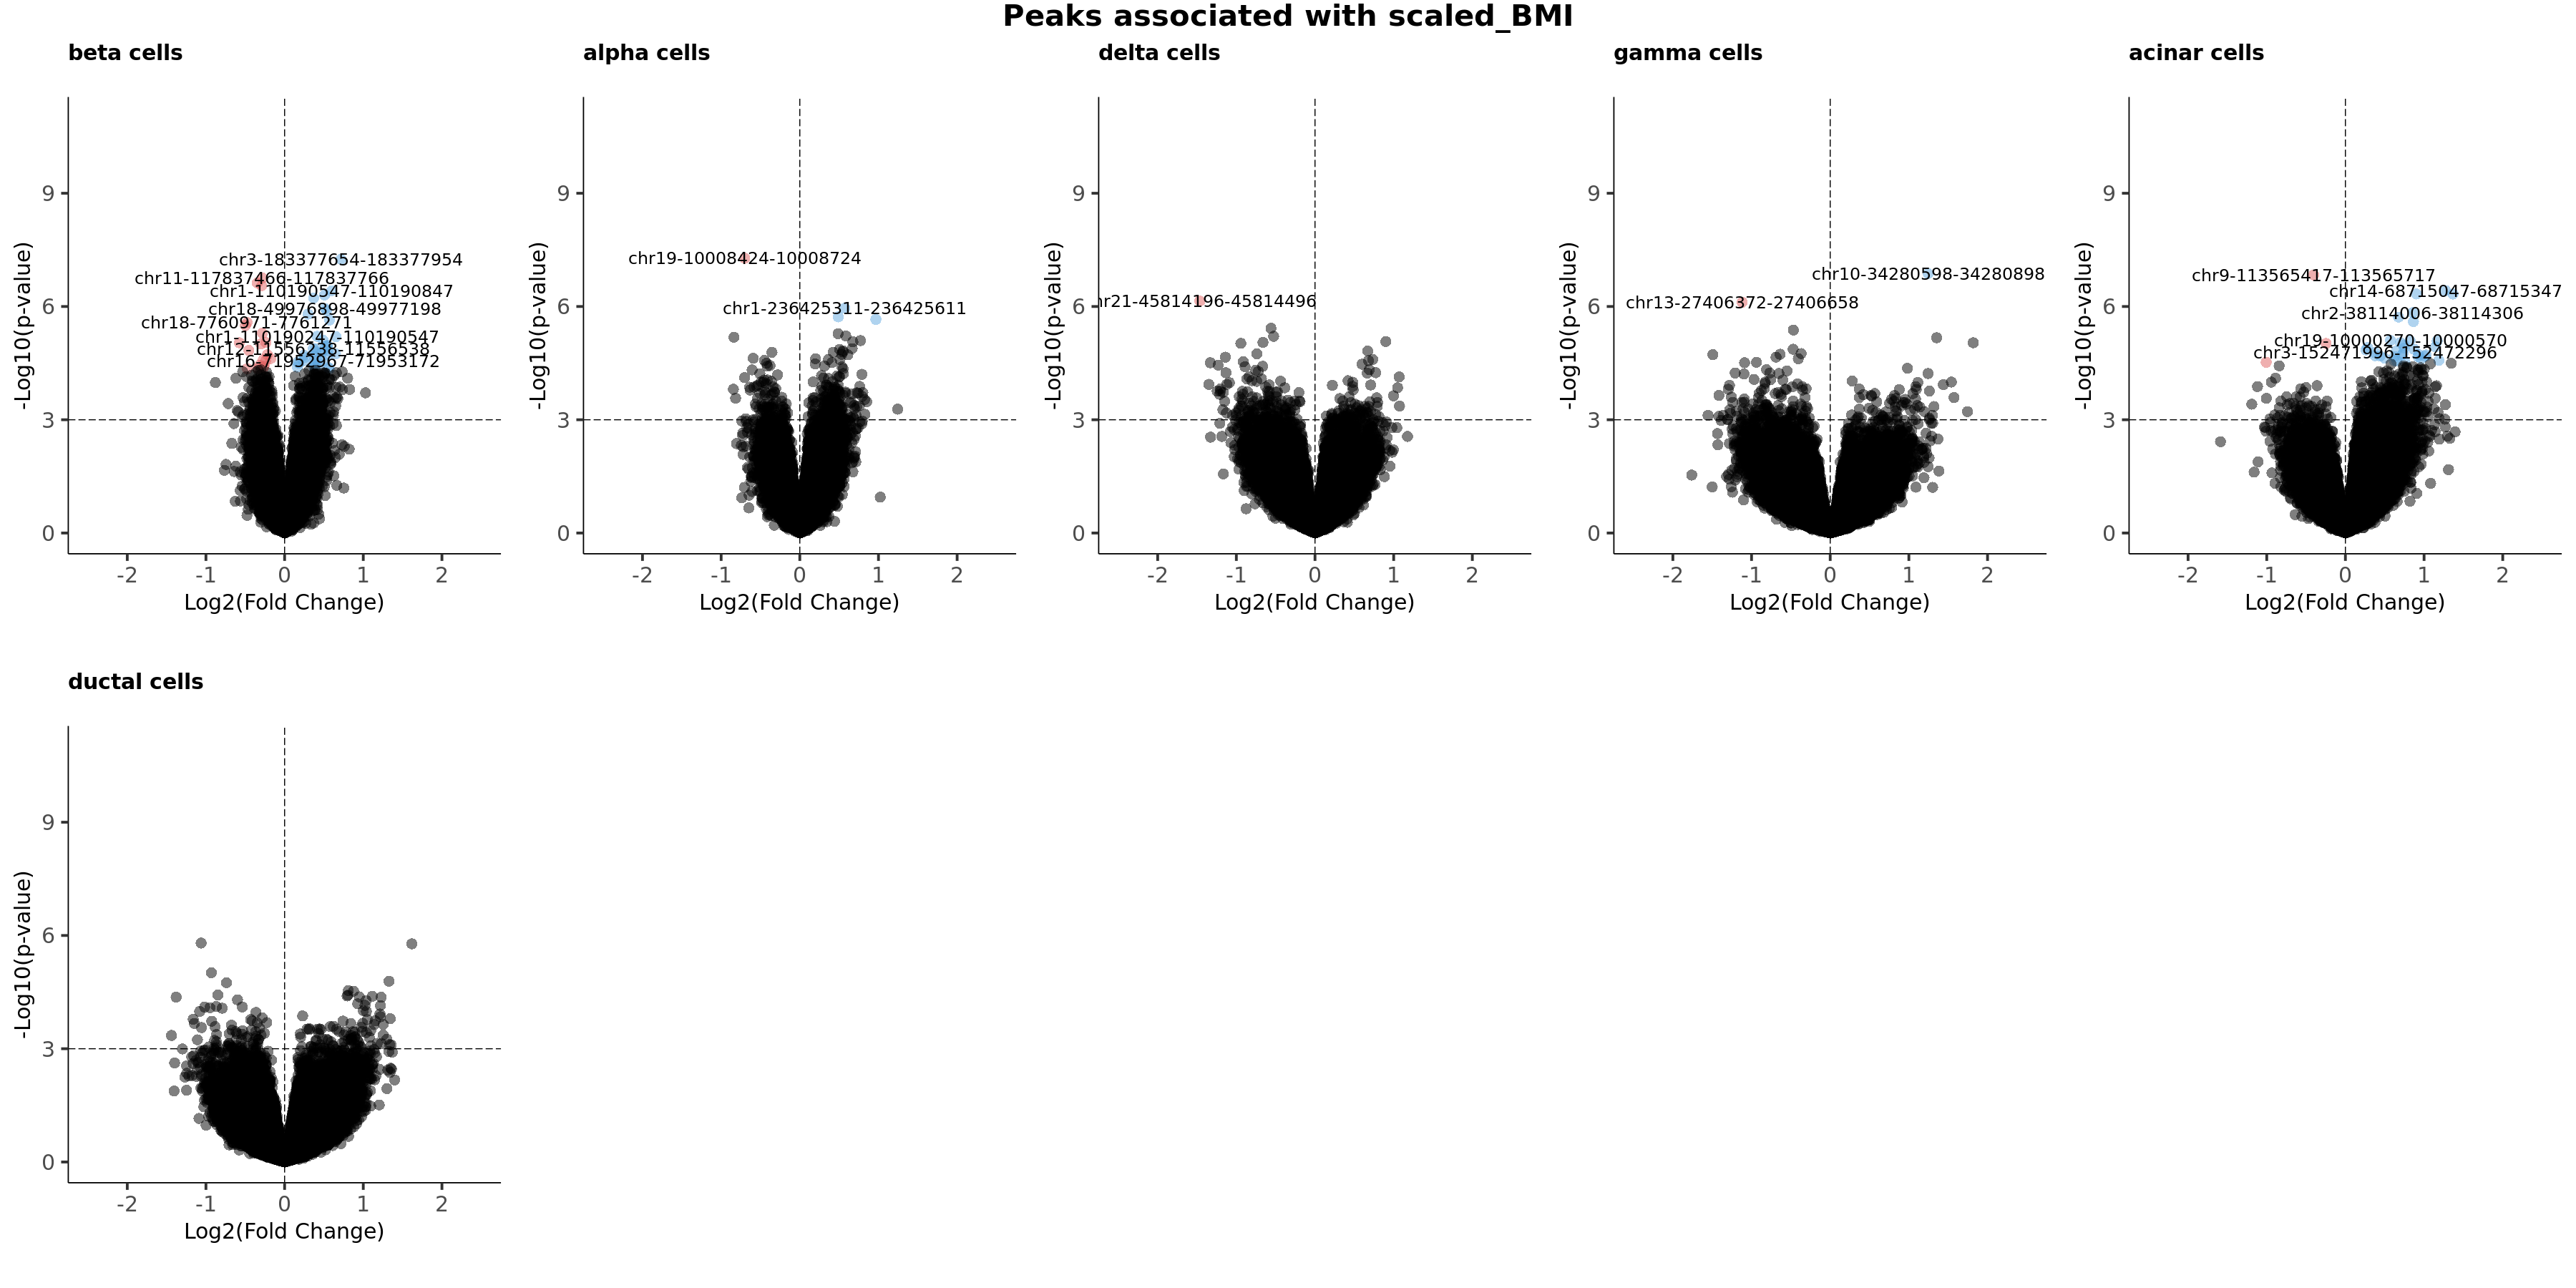

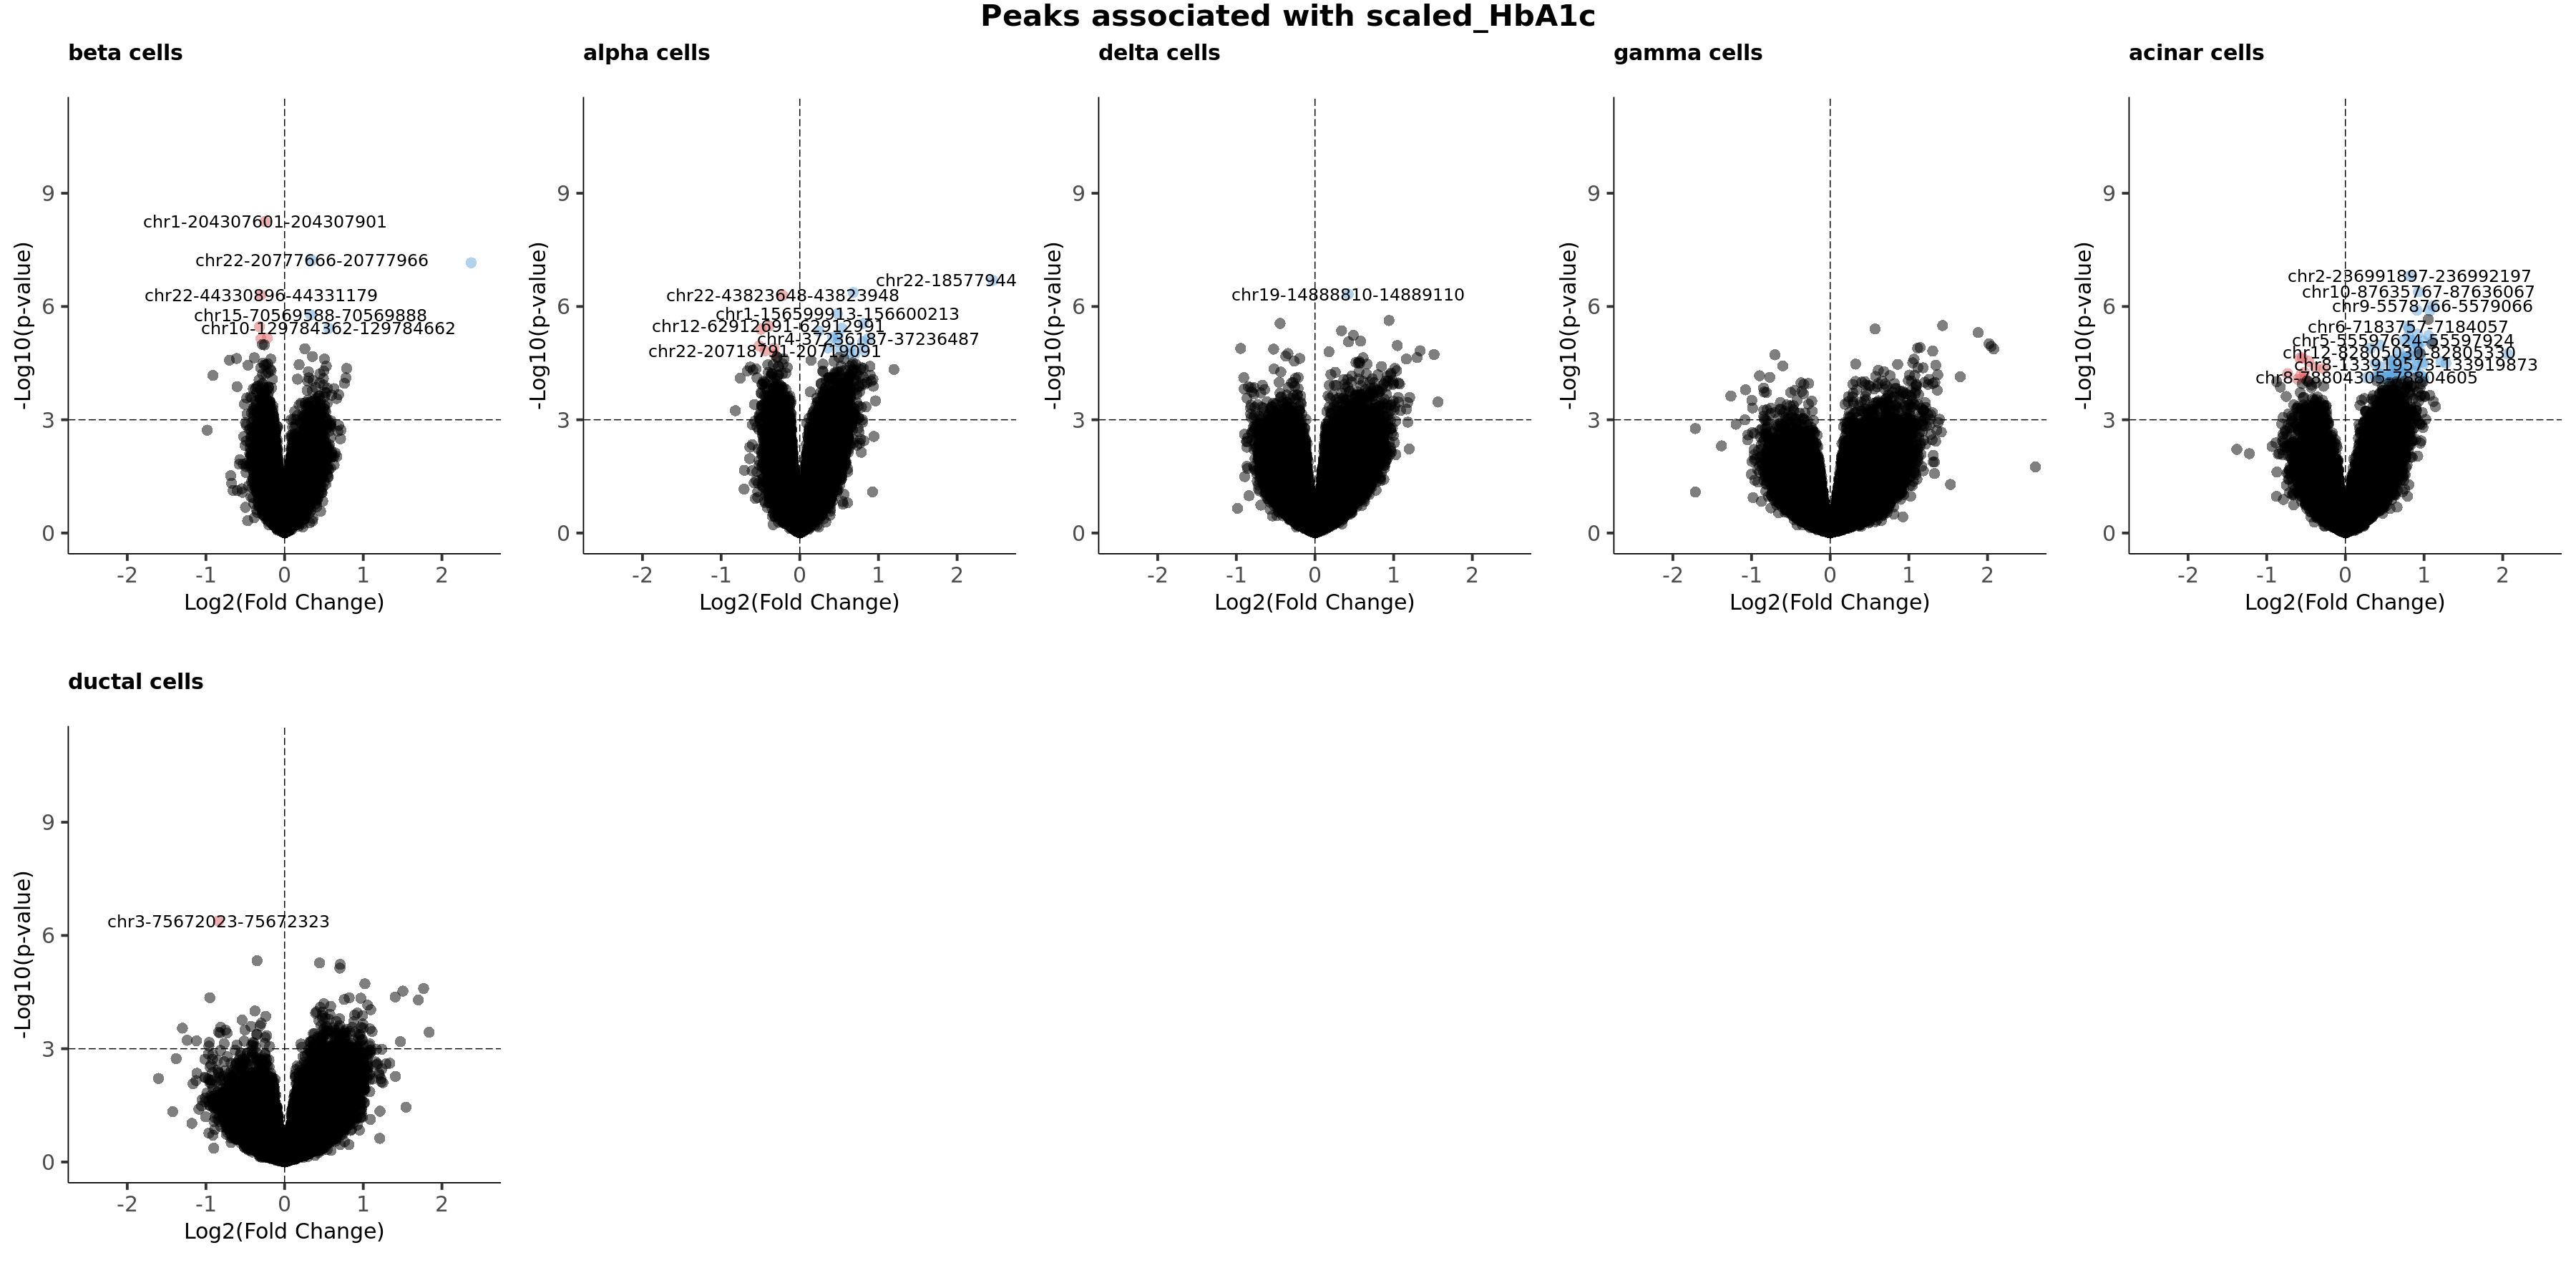

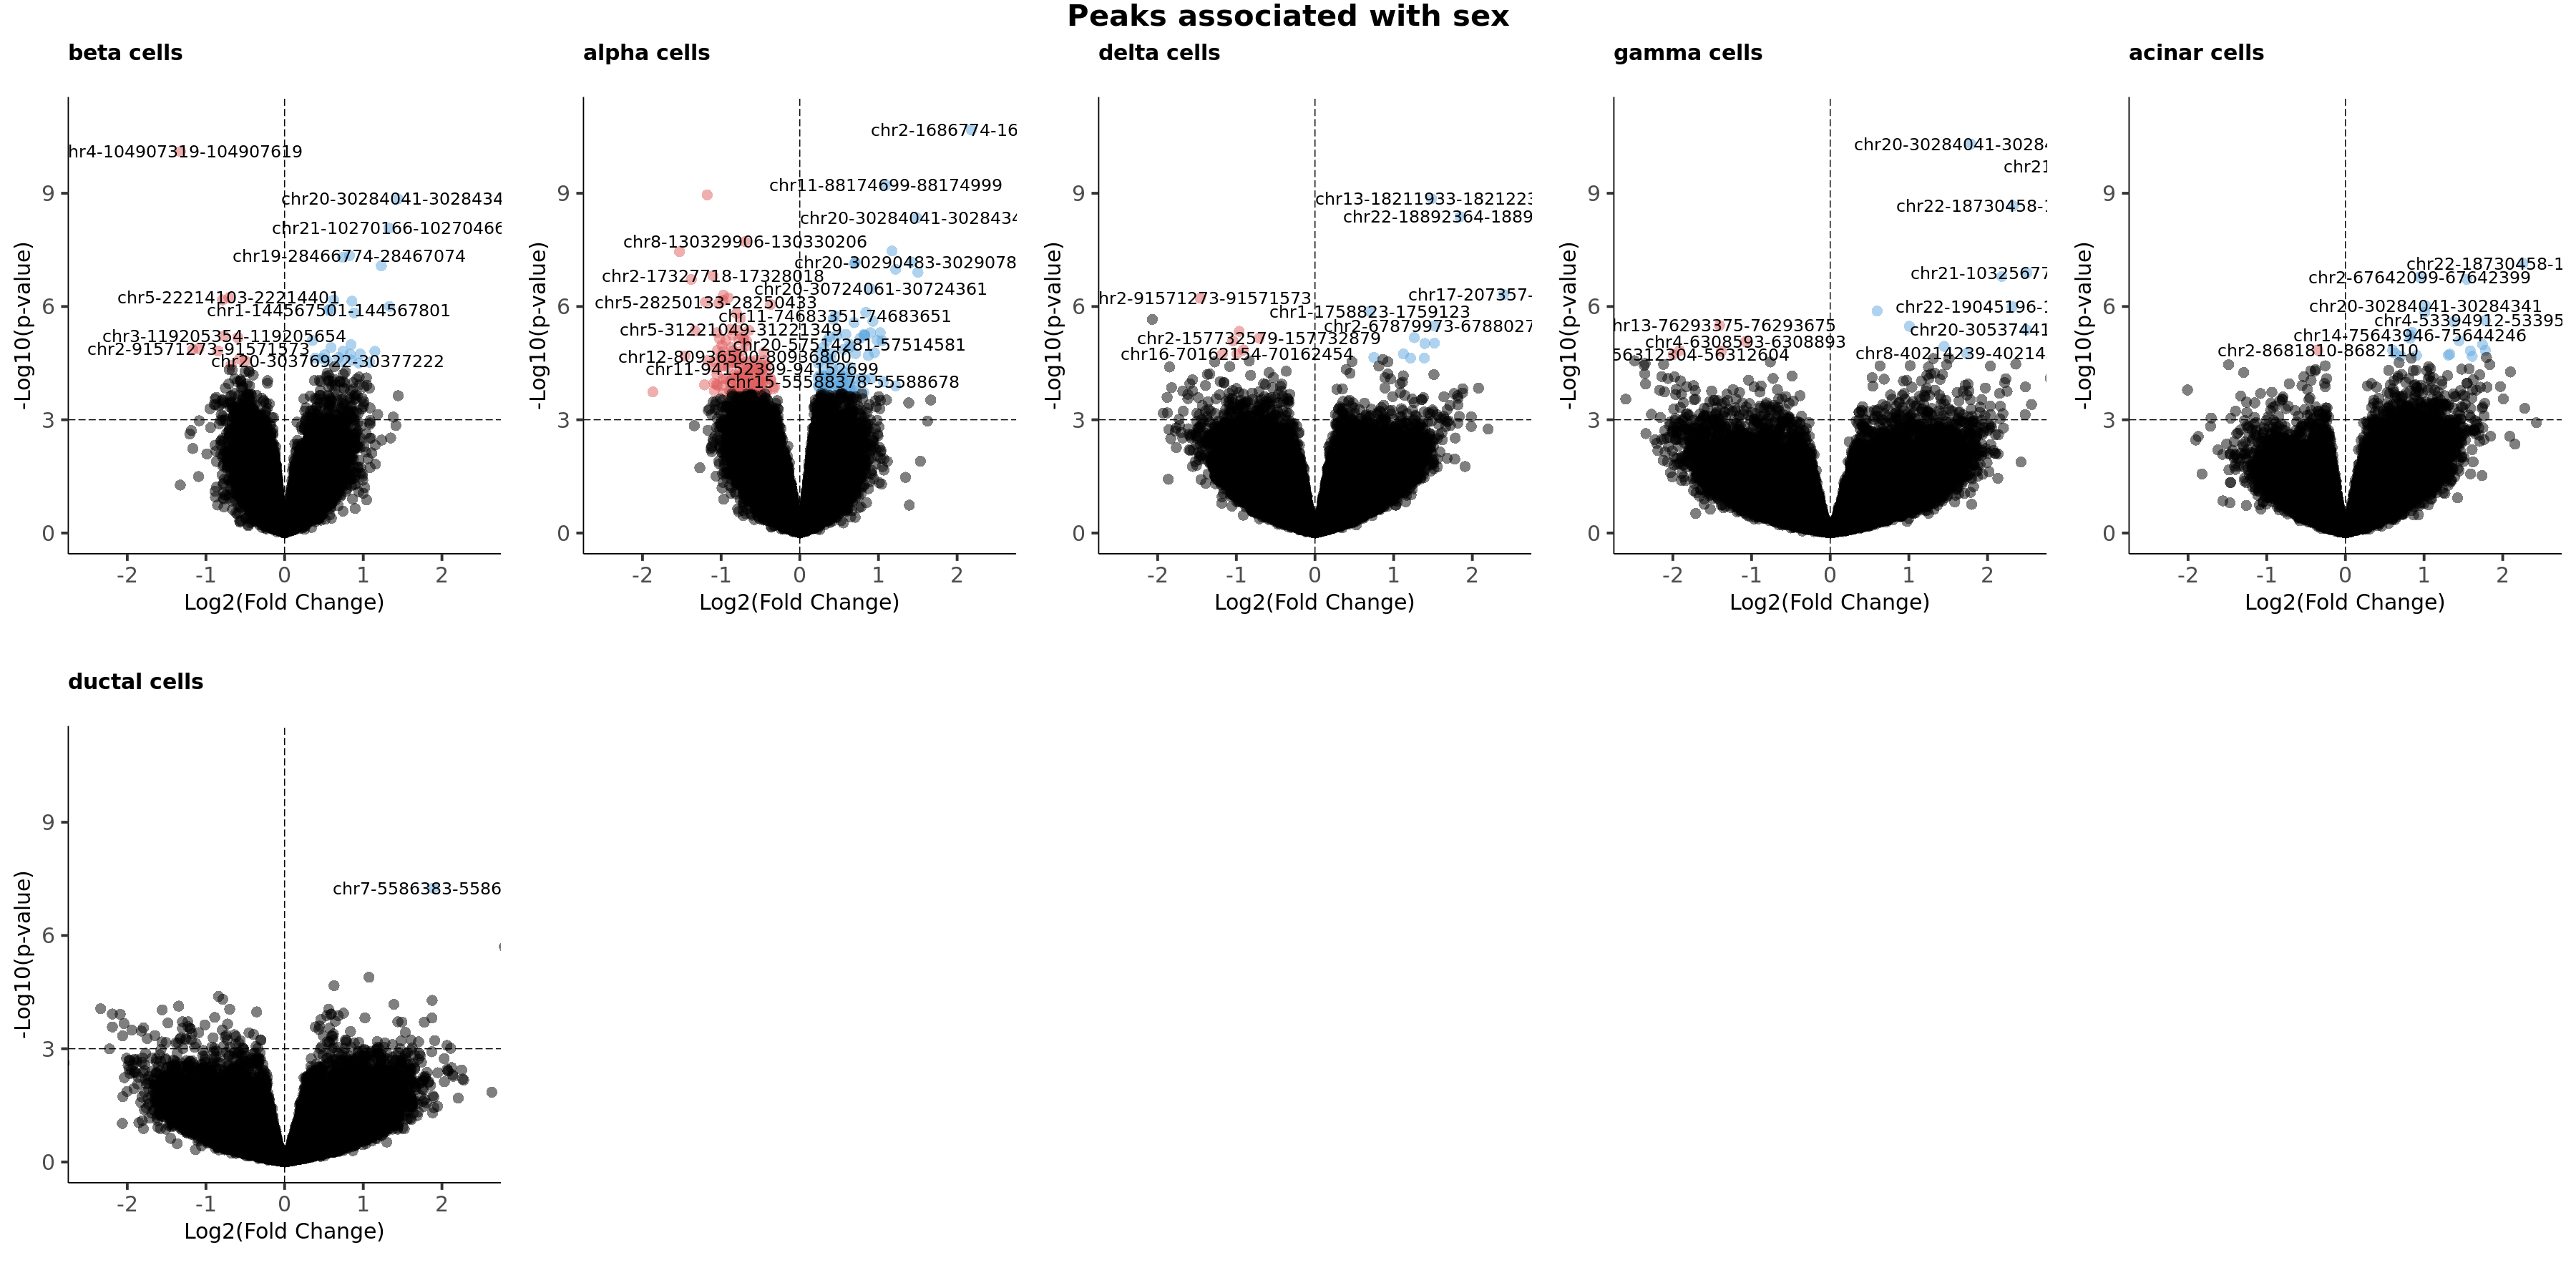

In [29]:
# Run function to make volcano plots
variables <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')

for (var in variables){
    plot_list <- list()
    for (cell in joint_celltypes){
        fp <- file.path(deseq_outdir, var, sprintf('ATAC_deseq_v4.%s.%s.tsv',var, cell))
        title <- sprintf('%s cells', cell)
        plot_list[[cell]] <- make_volcano_plot(fp, title, cell, '#60A7E0', '#E06060')
    }

    options(repr.plot.width = 30, repr.plot.height=15)
    fig <- ggarrange(plotlist = plot_list, nrow=2, ncol=5)
    fig <- annotate_figure(fig, top=text_grob(sprintf('Peaks associated with %s', var),
                           color = 'black', face='bold', size=25))
    print(fig)
}